https://towardsdatascience.com/t-sne-python-example-1ded9953f26

In [23]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [24]:
X, y = load_digits(return_X_y=True)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\datasets\base.py:550: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = data[:, -1].astype(np.int)


In [25]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [5]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [8]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()

    obj_func = _kl_divergence

    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])

    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [12]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)

    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)

    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))

    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    
    return kl_divergence, grad

In [14]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"" gradient norm = %.7f"
                              % (i + 1, error, grad_norm))

        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break

        if grad_norm <= min_grad_norm:
            break
    return p


In [15]:
X_embedded = fit(X)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000050
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000059
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000090
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000151
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000272
[t-SNE] Iteration 7: error = 4.0229668, gradient norm = 0.0000521
[t-SNE] Iteration 8: error = 4.0229642, gradient norm = 0.0001060
[t-SNE] Iteration 9: error = 4.0229524, gradient norm = 0.0002274
[t-SNE] Iteration 10: error = 4.0228929, gradient norm = 0.0005126
[t-SNE] Iteration 11: error = 4.0225622, gradient norm = 0.0012085
[t-SNE] Iteration 12: error = 4.0205724, gradient norm = 0.0029473
[t-SNE] Iteration 13: error = 4.0081365, gradient norm = 0.0070585
[t-SNE] Iteration 14: error = 3.9408847, gradient norm = 0.0137653
[t-SNE] Iteration 15: error = 3.7255473, gradient norm = 0.0176916
[t-S

[t-SNE] Iteration 124: error = 0.9975188, gradient norm = 0.0004765
[t-SNE] Iteration 125: error = 0.9957697, gradient norm = 0.0004674
[t-SNE] Iteration 126: error = 0.9940308, gradient norm = 0.0004719
[t-SNE] Iteration 127: error = 0.9922809, gradient norm = 0.0004685
[t-SNE] Iteration 128: error = 0.9905217, gradient norm = 0.0004614
[t-SNE] Iteration 129: error = 0.9887712, gradient norm = 0.0004458
[t-SNE] Iteration 130: error = 0.9870843, gradient norm = 0.0004373
[t-SNE] Iteration 131: error = 0.9855221, gradient norm = 0.0004798
[t-SNE] Iteration 132: error = 0.9839481, gradient norm = 0.0004717
[t-SNE] Iteration 133: error = 0.9823542, gradient norm = 0.0004492
[t-SNE] Iteration 134: error = 0.9807801, gradient norm = 0.0004490
[t-SNE] Iteration 135: error = 0.9792282, gradient norm = 0.0004400
[t-SNE] Iteration 136: error = 0.9776969, gradient norm = 0.0004233
[t-SNE] Iteration 137: error = 0.9761831, gradient norm = 0.0004320
[t-SNE] Iteration 138: error = 0.9746775, gradie

[t-SNE] Iteration 247: error = 0.8660379, gradient norm = 0.0002576
[t-SNE] Iteration 248: error = 0.8652475, gradient norm = 0.0002567
[t-SNE] Iteration 249: error = 0.8644426, gradient norm = 0.0002594
[t-SNE] Iteration 250: error = 0.8636237, gradient norm = 0.0002589
[t-SNE] Iteration 251: error = 0.8627891, gradient norm = 0.0002544
[t-SNE] Iteration 252: error = 0.8619397, gradient norm = 0.0002552
[t-SNE] Iteration 253: error = 0.8610768, gradient norm = 0.0002628
[t-SNE] Iteration 254: error = 0.8601986, gradient norm = 0.0002593
[t-SNE] Iteration 255: error = 0.8593057, gradient norm = 0.0002635
[t-SNE] Iteration 256: error = 0.8583964, gradient norm = 0.0002579
[t-SNE] Iteration 257: error = 0.8574691, gradient norm = 0.0002570
[t-SNE] Iteration 258: error = 0.8565201, gradient norm = 0.0002653
[t-SNE] Iteration 259: error = 0.8555428, gradient norm = 0.0002669
[t-SNE] Iteration 260: error = 0.8545335, gradient norm = 0.0002663
[t-SNE] Iteration 261: error = 0.8534881, gradie

[t-SNE] Iteration 369: error = 0.8124461, gradient norm = 0.0001555
[t-SNE] Iteration 370: error = 0.8122355, gradient norm = 0.0001440
[t-SNE] Iteration 371: error = 0.8120272, gradient norm = 0.0001651
[t-SNE] Iteration 372: error = 0.8118196, gradient norm = 0.0001774
[t-SNE] Iteration 373: error = 0.8116108, gradient norm = 0.0001581
[t-SNE] Iteration 374: error = 0.8114032, gradient norm = 0.0001438
[t-SNE] Iteration 375: error = 0.8111974, gradient norm = 0.0001528
[t-SNE] Iteration 376: error = 0.8109910, gradient norm = 0.0001594
[t-SNE] Iteration 377: error = 0.8107837, gradient norm = 0.0001292
[t-SNE] Iteration 378: error = 0.8105776, gradient norm = 0.0001361
[t-SNE] Iteration 379: error = 0.8103711, gradient norm = 0.0001496
[t-SNE] Iteration 380: error = 0.8101638, gradient norm = 0.0001460
[t-SNE] Iteration 381: error = 0.8099572, gradient norm = 0.0001810
[t-SNE] Iteration 382: error = 0.8097498, gradient norm = 0.0001986
[t-SNE] Iteration 383: error = 0.8095409, gradie

[t-SNE] Iteration 490: error = 0.7917299, gradient norm = 0.0001018
[t-SNE] Iteration 491: error = 0.7915973, gradient norm = 0.0001065
[t-SNE] Iteration 492: error = 0.7914643, gradient norm = 0.0001100
[t-SNE] Iteration 493: error = 0.7913308, gradient norm = 0.0001077
[t-SNE] Iteration 494: error = 0.7911969, gradient norm = 0.0001046
[t-SNE] Iteration 495: error = 0.7910629, gradient norm = 0.0001158
[t-SNE] Iteration 496: error = 0.7909290, gradient norm = 0.0001451
[t-SNE] Iteration 497: error = 0.7907975, gradient norm = 0.0002265
[t-SNE] Iteration 498: error = 0.7906676, gradient norm = 0.0003074
[t-SNE] Iteration 499: error = 0.7905309, gradient norm = 0.0003032
[t-SNE] Iteration 500: error = 0.7903865, gradient norm = 0.0001643
[t-SNE] Iteration 501: error = 0.7902504, gradient norm = 0.0001525
[t-SNE] Iteration 502: error = 0.7901187, gradient norm = 0.0002265
[t-SNE] Iteration 503: error = 0.7899796, gradient norm = 0.0001112
[t-SNE] Iteration 504: error = 0.7898485, gradie

[t-SNE] Iteration 612: error = 0.7723885, gradient norm = 0.0001128
[t-SNE] Iteration 613: error = 0.7722638, gradient norm = 0.0001128
[t-SNE] Iteration 614: error = 0.7721377, gradient norm = 0.0001117
[t-SNE] Iteration 615: error = 0.7720106, gradient norm = 0.0001095
[t-SNE] Iteration 616: error = 0.7718827, gradient norm = 0.0001073
[t-SNE] Iteration 617: error = 0.7717545, gradient norm = 0.0001083
[t-SNE] Iteration 618: error = 0.7716259, gradient norm = 0.0001085
[t-SNE] Iteration 619: error = 0.7714973, gradient norm = 0.0001098
[t-SNE] Iteration 620: error = 0.7713689, gradient norm = 0.0001180
[t-SNE] Iteration 621: error = 0.7712409, gradient norm = 0.0001217
[t-SNE] Iteration 622: error = 0.7711132, gradient norm = 0.0001185
[t-SNE] Iteration 623: error = 0.7709863, gradient norm = 0.0001223
[t-SNE] Iteration 624: error = 0.7708608, gradient norm = 0.0001341
[t-SNE] Iteration 625: error = 0.7707366, gradient norm = 0.0001410
[t-SNE] Iteration 626: error = 0.7706131, gradie

[t-SNE] Iteration 734: error = 0.7628259, gradient norm = 0.0000785
[t-SNE] Iteration 735: error = 0.7627642, gradient norm = 0.0000718
[t-SNE] Iteration 736: error = 0.7627026, gradient norm = 0.0000714
[t-SNE] Iteration 737: error = 0.7626411, gradient norm = 0.0000718
[t-SNE] Iteration 738: error = 0.7625798, gradient norm = 0.0000724
[t-SNE] Iteration 739: error = 0.7625184, gradient norm = 0.0000746
[t-SNE] Iteration 740: error = 0.7624571, gradient norm = 0.0000684
[t-SNE] Iteration 741: error = 0.7623960, gradient norm = 0.0000711
[t-SNE] Iteration 742: error = 0.7623350, gradient norm = 0.0000712
[t-SNE] Iteration 743: error = 0.7622740, gradient norm = 0.0000714
[t-SNE] Iteration 744: error = 0.7622132, gradient norm = 0.0000715
[t-SNE] Iteration 745: error = 0.7621523, gradient norm = 0.0000712
[t-SNE] Iteration 746: error = 0.7620914, gradient norm = 0.0000653
[t-SNE] Iteration 747: error = 0.7620307, gradient norm = 0.0000673
[t-SNE] Iteration 748: error = 0.7619700, gradie

[t-SNE] Iteration 856: error = 0.7556655, gradient norm = 0.0001112
[t-SNE] Iteration 857: error = 0.7556080, gradient norm = 0.0001139
[t-SNE] Iteration 858: error = 0.7555494, gradient norm = 0.0000792
[t-SNE] Iteration 859: error = 0.7554916, gradient norm = 0.0000721
[t-SNE] Iteration 860: error = 0.7554343, gradient norm = 0.0000990
[t-SNE] Iteration 861: error = 0.7553764, gradient norm = 0.0001003
[t-SNE] Iteration 862: error = 0.7553193, gradient norm = 0.0001266
[t-SNE] Iteration 863: error = 0.7552611, gradient norm = 0.0001304
[t-SNE] Iteration 864: error = 0.7552019, gradient norm = 0.0000872
[t-SNE] Iteration 865: error = 0.7551439, gradient norm = 0.0000837
[t-SNE] Iteration 866: error = 0.7550864, gradient norm = 0.0001065
[t-SNE] Iteration 867: error = 0.7550280, gradient norm = 0.0000727
[t-SNE] Iteration 868: error = 0.7549708, gradient norm = 0.0000869
[t-SNE] Iteration 869: error = 0.7549133, gradient norm = 0.0000878
[t-SNE] Iteration 870: error = 0.7548559, gradie

[t-SNE] Iteration 978: error = 0.7484775, gradient norm = 0.0000740
[t-SNE] Iteration 979: error = 0.7484175, gradient norm = 0.0000739
[t-SNE] Iteration 980: error = 0.7483574, gradient norm = 0.0000794
[t-SNE] Iteration 981: error = 0.7482971, gradient norm = 0.0000798
[t-SNE] Iteration 982: error = 0.7482366, gradient norm = 0.0000882
[t-SNE] Iteration 983: error = 0.7481758, gradient norm = 0.0000803
[t-SNE] Iteration 984: error = 0.7481150, gradient norm = 0.0000687
[t-SNE] Iteration 985: error = 0.7480547, gradient norm = 0.0000814
[t-SNE] Iteration 986: error = 0.7479944, gradient norm = 0.0000870
[t-SNE] Iteration 987: error = 0.7479338, gradient norm = 0.0000766
[t-SNE] Iteration 988: error = 0.7478737, gradient norm = 0.0000790
[t-SNE] Iteration 989: error = 0.7478137, gradient norm = 0.0000771
[t-SNE] Iteration 990: error = 0.7477538, gradient norm = 0.0000796
[t-SNE] Iteration 991: error = 0.7476937, gradient norm = 0.0000770
[t-SNE] Iteration 992: error = 0.7476335, gradie

In [58]:
import matplotlib.pyplot as plt
import numpy as np

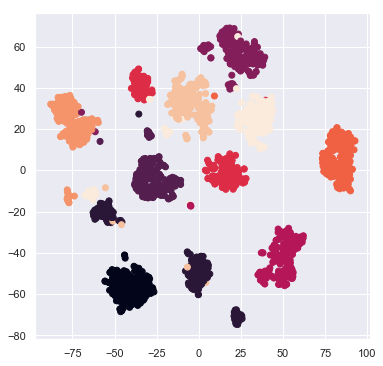

In [70]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(X_embedded[:,0], X_embedded[:,1],c = y)
plt.show()

In [ ]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:347: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\user\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\user\Anaconda3\lib\site-pa